In [3]:
% cd

/root


In [4]:
import zipfile as zf  
files = zf.ZipFile("chest_xray.zip", 'r')
files.extractall()
files.close()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch  
base_dir = "chest_xray" 

In [6]:
from torchvision import transforms
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(root=os.path.join(base_dir,"train"), transform=image_transforms['train'])
test_ds = ImageFolder(root=os.path.join(base_dir,"test"), transform=image_transforms['test'])
print(len(train_ds), len(test_ds))
class_names = train_ds.classes
print(class_names)

5216 640
['NORMAL', 'PNEUMONIA']


In [8]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

In [9]:
device

device(type='cuda')

In [10]:
images, labels = iter(train_dl).next()
images.shape

torch.Size([32, 3, 224, 224])

In [106]:
del net

In [11]:
import torchvision.models as models
net = models.resnet18(pretrained=True)
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [108]:
# for param in net.parameters():
#     param.requires_grad = False

In [12]:
import torch.nn as nn

num_ftrs = net.fc.in_features
net.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,2),
)

net = net.to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
weights = [1.0, .5]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)
# checking if GPU is available
if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()
EPOCHS = 20
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
def train(EPOCHS = 20):
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        total, correct = 0, 0
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print("Epoch: {}  Train Acc: {:.2f}".format(epoch, correct/total*100))

        net.eval()
        total, correct = 0, 0
        true_labels = []
        pred_labels = []
        for i, data in enumerate(test_dl, 0):
            inputs, labels = data
            true_labels += [t.cpu().numpy() for t in labels]
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            pred_labels += [p.cpu().numpy() for p in predicted]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        cm = confusion_matrix(true_labels, pred_labels)
        tn, fp, fn, tp = cm.ravel()
        ax = sns.heatmap(cm, annot=True, fmt="d")
        plt.show()
        print("Epoch: {}  Test Acc: {:.2f}".format(epoch, correct/total*100))
    print('Finished Training')

Epoch: 0  Train Acc: 93.73


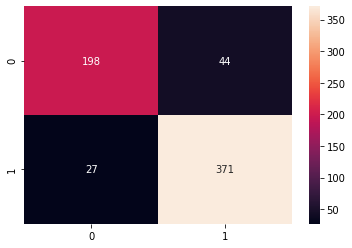

Epoch: 0  Test Acc: 88.91
Epoch: 1  Train Acc: 95.86


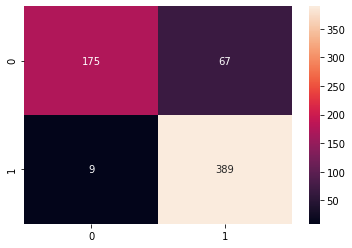

Epoch: 1  Test Acc: 88.12
Epoch: 2  Train Acc: 96.66


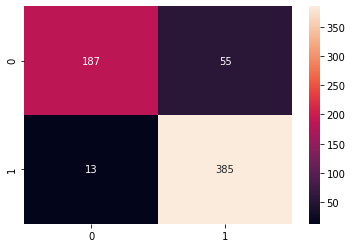

Epoch: 2  Test Acc: 89.38
Epoch: 3  Train Acc: 97.51


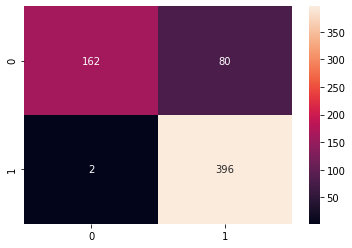

Epoch: 3  Test Acc: 87.19
Epoch: 4  Train Acc: 97.76


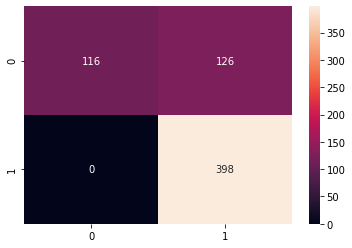

Epoch: 4  Test Acc: 80.31
Epoch: 5  Train Acc: 97.66


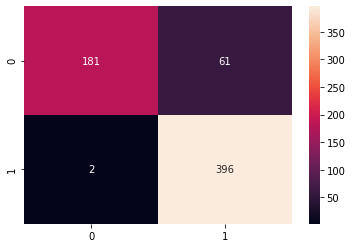

Epoch: 5  Test Acc: 90.16
Epoch: 6  Train Acc: 97.83


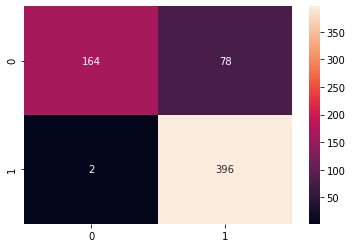

Epoch: 6  Test Acc: 87.50
Epoch: 7  Train Acc: 97.89


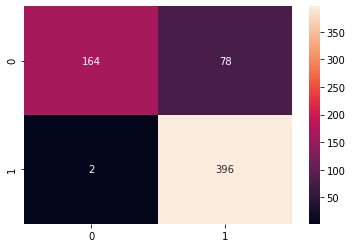

Epoch: 7  Test Acc: 87.50
Epoch: 8  Train Acc: 98.10


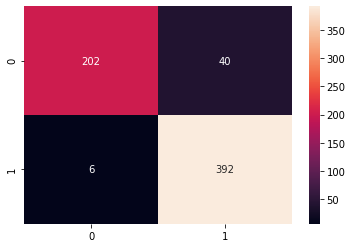

Epoch: 8  Test Acc: 92.81
Epoch: 9  Train Acc: 98.45


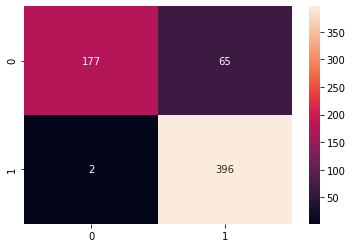

Epoch: 9  Test Acc: 89.53
Epoch: 10  Train Acc: 98.43


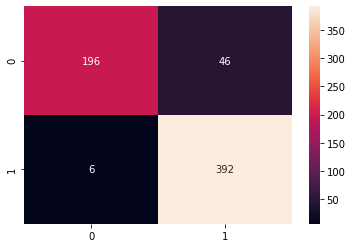

Epoch: 10  Test Acc: 91.88
Epoch: 11  Train Acc: 98.26


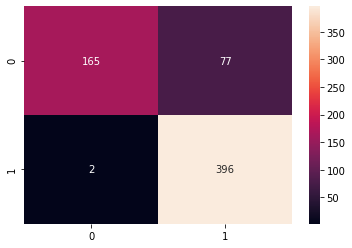

Epoch: 11  Test Acc: 87.66
Epoch: 12  Train Acc: 98.60


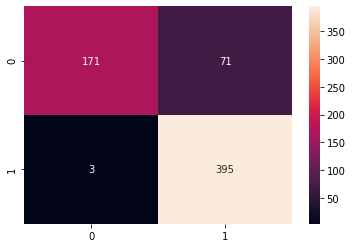

Epoch: 12  Test Acc: 88.44
Epoch: 13  Train Acc: 98.62


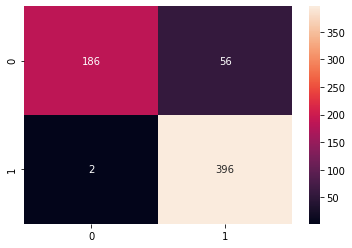

Epoch: 13  Test Acc: 90.94
Epoch: 14  Train Acc: 98.70


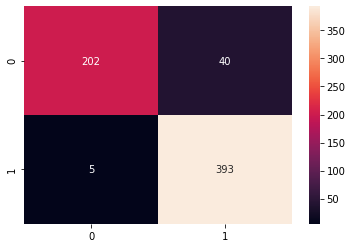

Epoch: 14  Test Acc: 92.97
Epoch: 15  Train Acc: 98.83


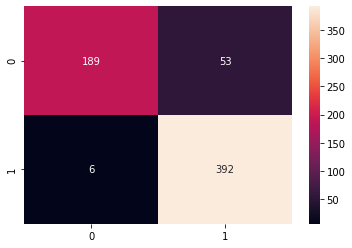

Epoch: 15  Test Acc: 90.78
Epoch: 16  Train Acc: 98.93


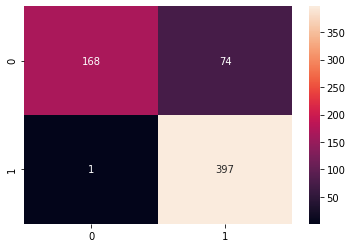

Epoch: 16  Test Acc: 88.28
Epoch: 17  Train Acc: 98.81


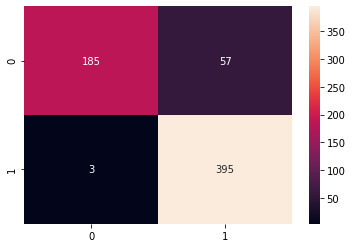

Epoch: 17  Test Acc: 90.62
Epoch: 18  Train Acc: 99.19


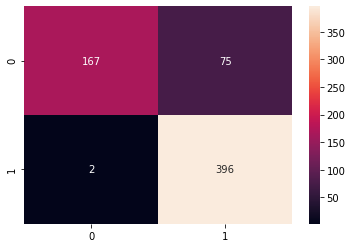

Epoch: 18  Test Acc: 87.97
Epoch: 19  Train Acc: 99.06


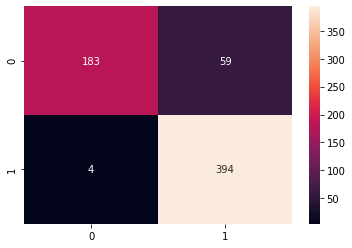

Epoch: 19  Test Acc: 90.16
Finished Training


In [29]:
train()

In [62]:
for param in net.parameters():
    param.requires_grad = True

In [ ]:
train(EPOCHS=50)